<a href="https://colab.research.google.com/github/Us9r/starlink-sentiment-analysis/blob/main/starlinkSentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Data Cleaning
import, load dataset dan, pre-processing text

## Import, load, dropna, drop duplicates

In [1]:
!pip install Sastrawi
!pip install googletrans==4.0.0-rc1 httpx>=0.23.0
!pip install tqdm
!pip install vaderSentiment

In [2]:
import pandas as pd
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.StopWordRemover.StopWordRemover import StopWordRemover
from Sastrawi.Dictionary.ArrayDictionary import ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from googletrans import Translator
from tqdm import tqdm

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/Us9r/starlink-sentiment-analysis/main/comments_with_replies%20(april).csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10857 entries, 0 to 10856
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Timestamp  10857 non-null  object
 1   Username   10856 non-null  object
 2   VideoID    10857 non-null  object
 3   Comment    10857 non-null  object
 4   Date       10857 non-null  object
dtypes: object(5)
memory usage: 424.2+ KB


In [5]:
df_comments = df.copy()
df_comments = df_comments[['Username','Comment']]

In [6]:
df_comments = df_comments.dropna()

In [7]:
df_comments = df_comments.drop_duplicates()

In [8]:
df_comments.head(3)

,Username,Comment
0,@AndreiSurya-n7f,Langkah langkah buat paket internet Gimna
1,@Edan27271,Punya elon musk❎\nPunya mas David✅
2,@littentamba4359,"Bng, bs spill powerbengny \nTrus beli d mn pow..."


## Case Folding

In [9]:
# Create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def casefolding(text):
    text = text.lower()
    return text

df_comments['Comment'] = df_comments['Comment'].apply(casefolding)

## Removal Special Characters

Menghapus Angka
Menghapus Tanda Baca
Menghapus White Space
Menggunakan strip() untuk Menghapus Whitespace di Awal dan Akhir
Menggunakan replace() untuk Menghapus Whitespace di Seluruh String

In [10]:
def remove_special_characters(text):
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.strip()  # Remove whitespace at the beginning and end
    text = text.replace(" ", " ") # Remove all whitespace (if you want to replace multiple spaces with a single space)
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention dan special characters
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka

    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text

df_comments['Comment'] = df_comments['Comment'].apply(remove_special_characters)

In [11]:
hapus_iklan = ["cair", "anti mangkir", "depo", "gacor", "wede", "wd", "scatter", "rungkat","javaland","s ago"]

# Gabungkan string dengan operator '|' (OR)
pola = '|'.join(hapus_iklan)

jumlah_baris_dihapus = df_comments['Comment'].str.contains(pola, case=False).sum()
jumlah_baris_dihapus

np.int64(68)

In [12]:
df_comments = df_comments[~df_comments['Comment'].str.contains(pola, case=False)] #menghapus iklan

##  Stopword Removal (Filtering)

In [13]:
from collections import Counter
# identifikasi
# Gabungkan semua komentar menjadi satu string panjang
all_text = ' '.join(df_comments['Comment'].tolist())

# Hitung frekuensi kata
word_counts = Counter(word_tokenize(all_text))

# Tampilkan kata-kata yang paling sering muncul
print(word_counts.most_common(20)) # Menampilkan 20 kata teratas

[('di', 3273), ('bisa', 1883), ('bang', 1825), ('starlink', 1654), ('yg', 1651), ('ada', 1447), ('ini', 1433), ('buat', 1347), ('internet', 1110), ('yang', 1106), ('dan', 1061), ('nya', 1051), ('itu', 970), ('ya', 857), ('gak', 833), ('ga', 806), ('untuk', 795), ('kalo', 781), ('ke', 758), ('kalau', 666)]


In [14]:
# Definisikan stopword custom
stopword_custom = ["hadir", "first", "lah", "pertama","ada", "ini",'iya','yaa','nya','na','sih','ku',"di","ya","loh","kah","woi","woii","woy","p","nihh","s ago","pertamaxx", "d", "mn", "trus", "dri", "kn", "kan", "bg", "bng", "bang", "mas","bs", "david", "brendi", "david brendi", "yg", "yng", "yang", "nya", "ya", "y", "kalo", "aja", "sih","bisa"]

# Gabungkan stopword bawaan dan custom
stop_words = StopWordRemoverFactory().get_stop_words() + stopword_custom

# Buat objek StopWordRemover
new_array = ArrayDictionary(stop_words)
stop_words_remover_new = StopWordRemover(new_array)

# Fungsi untuk menghapus stopwords
def stopword(str_text):
    str_text = stop_words_remover_new.remove(str_text)
    return str_text

# Terapkan pada kolom 'Comment'
df_comments['Comment_NoStopword'] = df_comments['Comment'].apply(lambda x: stopword(x))

In [15]:
# Identifikasi dan hapus baris kosong setelah stopword removal
df_comments = df_comments[df_comments['Comment'] != '']
df_comments = df_comments[df_comments['Comment'].str.strip() != ''] #tambahan untuk menghapus spasi kosong

## Tokenizing
with end result of df_tokenized

In [16]:
def tokenize_text(text):
    # Normalisasi kata-kata informal
    normalization_dict = {
        "gmna": "gimana",
        "gk": "tidak",
        "gak": "tidak",
        "ga": "tidak",
        "gaa": "tidak",
        "engga": "tidak",
        "kl": "mungkin",
        "klo": "mungkin",
        "hrga": "harga",
        "dpt": "dapat",
        "powerbengny": "power bank",
        "powerbngny": "power bank",
        "powerbankny": "power bank",
        "starbak": "starlink",
        "bs":"bisa"
    }

    # Tokenisasi dengan split dan normalisasi
    tokens = []
    for word in text.split():
        if word in normalization_dict:
            tokens.append(normalization_dict[word])
        else:
            tokens.append(word)

    return tokens

df_comments['Comments_Tokens'] = df_comments['Comment_NoStopword'].apply(lambda x: tokenize_text(x))

In [17]:
df_tokenized = df_comments[df_comments['Comments_Tokens'].map(lambda d: len(d)) > 0]

#### saving df_tokenized

In [20]:
df_tokenized.to_csv('df_tokenized.csv', index=False)

## Stemming
Elapsed for 58 minutes to generate df_stemmed

In [22]:
tqdm.pandas() #progress bar

def stemming(text_tokens):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    stemmed_tokens = [stemmer.stem(token) for token in text_tokens]
    return stemmed_tokens

# Terapkan stemming dengan progress bar
df_tokenized['Comments_Stemming'] = df_tokenized['Comments_Tokens'].progress_apply(lambda x: stemming(x))

100%|██████████| 10604/10604 [58:45<00:00,  3.01it/s]
<ipython-input-22-8a4b5a5b07b8>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tokenized['Comments_Stemming'] = df_tokenized['Comments_Tokens'].progress_apply(lambda x: stemming(x))


In [30]:
df_stemmed = df_tokenized.copy()
df_stemmed.to_csv('df_stemmed.csv', index=False)

In [31]:
df_stemmed.head(3)

,Username,Comment,Comment_NoStopword,Comments_Tokens,Comments_Stemming
0,@AndreiSurya-n7f,langkah langkah buat paket internet gimna,langkah langkah buat paket internet gimna,"[langkah, langkah, buat, paket, internet, gimna]","[langkah, langkah, buat, paket, internet, gimna]"
1,@Edan27271,punya elon musk punya mas david,punya elon musk punya david,"[punya, elon, musk, punya, david]","[punya, elon, musk, punya, david]"
2,@littentamba4359,bng bs spill powerbengny trus beli d mn power...,bs spill powerbengny beli mn powerbngny bng m...,"[bisa, spill, power bank, beli, mn, power bank...","[bisa, spill, power bank, beli, mn, power bank..."


## Translating
Elapsed For 2 Hours 13 minutes to generate df_translated

In [27]:
# jika diperlukan
df_stemmed = pd.read_csv('df_stemmed.csv')
df_stemmed = df_stemmed['Comments_Stemming']

"\njika diperlukan\ndf_stemmed = pd.read_csv('df_stemmed.csv')\ndf_stemmed = df_stemmed['Comments_Stemming']\n"

In [32]:
translator = Translator()

def translate_comment(comment_tokens):
    try:
        # Gabungkan token menjadi satu string sebelum diterjemahkan
        comment_text = " ".join(comment_tokens)
        translation = translator.translate(comment_text, dest='en').text
        return translation
    except Exception as e:
        print(f"Translation error for comment '{comment_text}': {e}")
        return comment_text

# Terapkan terjemahan pada kolom 'Comments_Stemming' di df_stemmed
df_stemmed['Translated_Comment'] = df_stemmed['Comments_Stemming'].progress_apply(translate_comment)

# Simpan hasil terjemahan di df_translated
df_translated = df_stemmed[['Translated_Comment']].copy()

  3%|▎         | 324/10604 [04:05<1:05:08,  2.63it/s]

Translation error for comment 'rada kurang masih lumayan speedny': the JSON object must be str, bytes or bytearray, not NoneType
Translation error for comment 'serius nanya kalau bawa traveling guna pesawat kah bawa': the JSON object must be str, bytes or bytearray, not NoneType


 36%|███▌      | 3831/10604 [48:28<1:37:33,  1.16it/s]

Translation error for comment '   ': sequence item 0: expected str instance, NoneType found


 61%|██████    | 6490/10604 [1:22:02<30:13,  2.27it/s]

Translation error for comment 'kalau orang kaya tinggal pelosok tidak internet fiber sinyal semua operator edge perangkat sangat cocok buat': the JSON object must be str, bytes or bytearray, not NoneType
Translation error for comment 'tidak cocok duit': the JSON object must be str, bytes or bytearray, not NoneType


 92%|█████████▏| 9754/10604 [2:03:47<07:25,  1.91it/s]

Translation error for comment 'kayak operator kuasa diindo tidak bakal diam deh entah nuntut harga paket starlink dinaikin apa': the JSON object must be str, bytes or bytearray, not NoneType


100%|██████████| 10604/10604 [2:13:57<00:00,  1.32it/s]


#2. Vader Sentiment Analysis
Sentimen Keseluruhan Positif: Nilai Overall Sentiment adalah "Positive", yang menandakan bahwa sentimen positif mendominasi dalam kumpulan data komentar yang dianalisis.

> * 'Overall Sentiment': 'Positive',
> * 'Positive Count': 3342,
> * 'Negative Count': 1703,
> * 'Neutral Count': 5558,
> * 'Positive Percentage': 31.519381307177213,
> * 'Negative Percentage': 16.06149203055739,
> * 'Neutral Percentage': 52.41912666226539}

In [3]:
# jika diperlukan
df_translated = pd.read_csv('df_translated.csv')

Hapus sisa eror translation

In [7]:
error_values = [
    'rada kurang masih lumayan speedny',
    'serius nanya kalau bawa traveling guna pesawat kah bawa',
    '   ',
    'kalau orang kaya tinggal pelosok tidak internet fiber sinyal semua operator edge perangkat sangat cocok buat',
    'tidak cocok duit',
    'kayak operator kuasa diindo tidak bakal diam deh entah nuntut harga paket starlink dinaikin apa'
]

# Filter rows containing error values in 'Comments_Stemming' column
filtered_df = df_translated[~df_translated['Translated_Comment'].apply(lambda x: any(val in x for val in error_values))]

## Labeling

In [8]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

tqdm.pandas()

analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    scores = analyzer.polarity_scores(text)
    return scores

df_translated['Sentiment_Scores'] = df_translated['Translated_Comment'].progress_apply(analyze_sentiment)

100%|██████████| 10603/10603 [00:00<00:00, 17318.08it/s]


## Dividing result into each collumn

In [9]:
df_translated = pd.concat([df_translated.drop(['Sentiment_Scores'], axis=1), df_translated['Sentiment_Scores'].apply(pd.Series)], axis=1)

In [16]:
def analyze_sentiment_results(df_translated):
    # Add a new column 'Sentiment' to store the sentiment labels
    df_sentiment = df_translated.copy()
    df_sentiment['Sentiment'] = ''

    # Apply sentiment classification based on 'compound' score
    df_sentiment.loc[df_sentiment['compound'] >= 0.05, 'Sentiment'] = 'Positive'
    df_sentiment.loc[df_sentiment['compound'] <= -0.05, 'Sentiment'] = 'Negative'
    df_sentiment.loc[df_sentiment['compound'].between(-0.05, 0.05), 'Sentiment'] = 'Neutral'

    # Calculate the overall sentiment
    overall_sentiment = 'Neutral'
    if df_sentiment['compound'].mean() >= 0.05: # Changed df_translated to df_sentiment
        overall_sentiment = 'Positive'
    elif df_sentiment['compound'].mean() <= -0.05: # Changed df_translated to df_sentiment
        overall_sentiment = 'Negative'

    # Count the number of positive, negative, and neutral sentiments
    positive_count = df_sentiment[df_sentiment['Sentiment'] == 'Positive'].shape[0] # Changed df_translated to df_sentiment
    negative_count = df_sentiment[df_sentiment['Sentiment'] == 'Negative'].shape[0] # Changed df_translated to df_sentiment
    neutral_count = df_sentiment[df_sentiment['Sentiment'] == 'Neutral'].shape[0] # Changed df_translated to df_sentiment

    # Calculate percentages
    total_count = df_sentiment.shape[0] # Changed df_translated to df_sentiment
    positive_percentage = (positive_count / total_count) * 100 if total_count > 0 else 0
    negative_percentage = (negative_count / total_count) * 100 if total_count > 0 else 0
    neutral_percentage = (neutral_count / total_count) * 100 if total_count > 0 else 0

    analysis = {
        'Overall Sentiment': overall_sentiment,
        'Positive Count': positive_count,
        'Negative Count': negative_count,
        'Neutral Count': neutral_count,
        'Positive Percentage': positive_percentage,
        'Negative Percentage': negative_percentage,
        'Neutral Percentage': neutral_percentage,
    }

    return analysis, df_sentiment  # Return both the analysis and the updated DataFrame

analysis_results, df_sentiment = analyze_sentiment_results(df_translated)

In [17]:
df_sentiment

,Translated_Comment,neg,neu,pos,compound,Sentiment
0,steps to make a gimna internet package,0.000,1.000,0.000,0.0000,Neutral
1,Have Elon Musk Has David,0.000,1.000,0.000,0.0000,Neutral
2,Can Spill Power Bank Buy Mn Power Bank BNG Mn ...,0.000,1.000,0.000,0.0000,Neutral
3,Pay which month,0.412,0.588,0.000,-0.1027,Negative
4,at the same time WiFi how,0.000,1.000,0.000,0.0000,Neutral
...,...,...,...,...,...,...
10598,greeted me,0.000,0.323,0.677,0.2732,Positive
10599,nih,0.000,1.000,0.000,0.0000,Neutral
10600,number one electoral district ddddd,0.000,0.755,0.245,0.0772,Positive
10601,Stralink kelling,0.000,1.000,0.000,0.0000,Neutral


## Result
df_sentiment

In [22]:
analysis_results

{'Overall Sentiment': 'Positive',
 'Positive Count': 3342,
 'Negative Count': 1703,
 'Neutral Count': 5558,
 'Positive Percentage': 31.519381307177213,
 'Negative Percentage': 16.06149203055739,
 'Neutral Percentage': 52.41912666226539}

# 3. Training ML model

In [23]:
# prompt: latih model naive bayes terhadap df_sentiment dengan tf_idf

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# Assuming df_sentiment is your DataFrame with 'Translated_Comment' and 'Sentiment' columns

# Prepare the data
X = df_sentiment['Translated_Comment']
y = df_sentiment['Sentiment']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the testing data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train a Multinomial Naive Bayes classifier
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = naive_bayes_classifier.predict(X_test_tfidf)

# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

    Negative       0.89      0.11      0.19       321
     Neutral       0.73      0.95      0.82      1128
    Positive       0.75      0.69      0.72       672

    accuracy                           0.74      2121
   macro avg       0.79      0.58      0.58      2121
weighted avg       0.76      0.74      0.69      2121



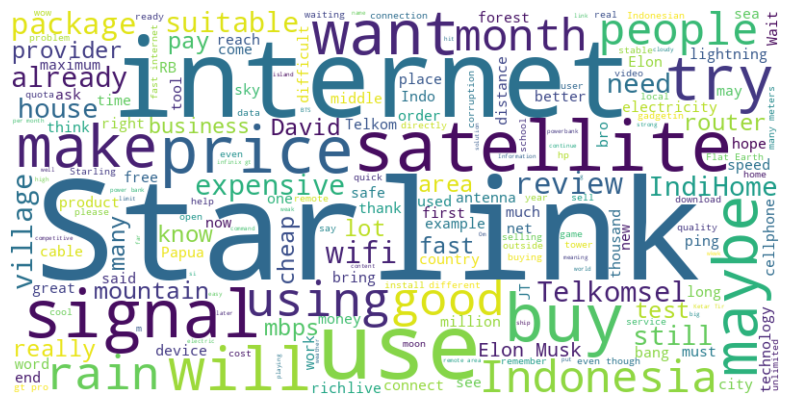

In [24]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming 'df_sentiment' is your DataFrame and 'Translated_Comment' column contains the text
text = " ".join(df_sentiment['Translated_Comment'].astype(str))

# Create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
